In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#external files
from preprocessing import FileIO
# from weaviate_interface import WeaviateClient
from weaviate_interface import WeaviateClient
from retrieval_evaluation import calc_hit_rate_scores, calc_mrr_scores
from reranker import ReRanker

#external libraries
from llama_index.finetuning import EmbeddingQAFinetuneDataset
import plotly.express as px

#standard library imports
from typing import List, Any, Dict, Tuple, Union
import time
import os

# utilities
from tqdm import tqdm
from rich import print
from dotenv import load_dotenv
env = load_dotenv('./.env', override=True)

### Load QA dataset

In [3]:
golden_dataset = EmbeddingQAFinetuneDataset.from_json("./data/golden_dataset.json")
len(golden_dataset.queries)

250

### Instantiate Weaviate client and set Class name

In [16]:
client = WeaviateClient(os.environ['WEAVIATE_API_KEY'], os.environ['WEAVIATE_ENDPOINT'])
class_name = 'Impact_theory_minilm_256'

#check if WCS instance is live and ready
client.is_live(), client.is_ready()

(True, True)

In [22]:
resp = client._hybrid_search('where are the locals at', class_name, limit=20)

In [23]:
resp

[{'content': "And what is that spell? Culture? Family pressures? All of the above? Yes. If you look at the world, there you see where it got to. The world is polluting and it doesn't give a shit. The world is on fire. Nobody gives a shit. Only the people, the locals, but the rest of the world is just watching. War is going on. Watching. Refugees are drowning. Little children are drowning. We are watching. The production, that is important. Money, that is important. Competition, that is important. People die in the hospitals because of the COVID. They don't talk about how to strengthen your own immune system. Why? We have shown in 2014, Tom, we have shown how to suppress effectively with a group of people. So the scientific evidence that within a quarter of an hour, using specific breathing techniques to alter the immune system, to make the innate immune system go down, that means the cytokine storm, which is the damaging factor of COVID, of COVID-19 damaging factor, is inflammation.",


Bad pipe message: %s [b'\xaa\xb5\xf9\x0c\xd8k\xd0\xb0\xb7\xa6\x95@\x8c_H\x93\x1a\x9a D3>YWs\x05&\x05\x11\x8d\x1a\xffe\xd45AO\x18\xd6\xa6\x17;\xf9\xafp3\x80a\x10&N\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t']
Bad pipe message: %s [b'\x08\x0b\x08\x04\x08\x05\x08']
Bad pipe message: %s [b'\x01\x05\x01\x06\x01']
Bad pipe message: %s [b'\tu \xb4~\xe7\x81\xbb\xd9\x94uj\x04\xec\x01\x8c\xc6\xe7\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00']
Bad pipe message: %s [b"\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0s\xc0w\x00\xc4\x00\xc3\xc0#\xc0'\x00g\x00@\xc0r\xc0v\x00\xbe\x00\xbd\xc0\n\xc0\x14\x009\x008\x00\x88\x00\x87\xc0\t

### Evaluate Retrieval methods

In [5]:
def execute_evaluation( dataset: EmbeddingQAFinetuneDataset, 
                        class_name: str, 
                        retriever: WeaviateClient,
                        reranker: ReRanker=None,
                        alpha: float=0.5,
                        retrieve_limit: int=5,
                        results_top_k: int=5,
                        rerank_top_k: int=5,
                        chunk_size: int=256,
                        display_properties: List[str]=['doc_id', 'content']
                        ) -> Tuple[int, int, int]:

    if results_top_k > retrieve_limit:  # we don't want to retrieve less results than the top_k that we want to see returned
        retrieve_limit = results_top_k
        
    reranker_name = reranker.model_name if reranker else "None"
    
    results_dict = {'n':retrieve_limit, 
                    'top_k': results_top_k,
                    'alpha': alpha,
                    'Retriever': retriever.model_name_or_path, 
                    'Ranker': reranker_name,
                    'chunk_size': chunk_size,
                    'kw_hit_rate': 0,
                    'kw_mrr': 0,
                    'vector_hit_rate': 0,
                    'vector_mrr': 0,
                    'hybrid_hit_rate':0,
                    'hybrid_mrr': 0,
                    'total_misses': 0,
                    'total_questions':0
                    }
    if reranker:
        results_dict['rerank_top_k'] = rerank_top_k  # have to build the results_dict before we can add this information
        
    start = time.perf_counter()
    for query_id, q in tqdm(dataset.queries.items(), 'Queries'):
        results_dict['total_questions'] += 1
        
        #make Keyword, Vector, and Hybrid calls to Weaviate host
        try:
            kw_response = retriever.keyword_search(request=q, class_name=class_name, limit=retrieve_limit, display_properties=display_properties)
            vector_response = retriever.vector_search(request=q, class_name=class_name, limit=retrieve_limit, display_properties=display_properties)
            hybrid_response = retriever._hybrid_search(request=q, class_name=class_name, alpha=alpha, limit=retrieve_limit, display_properties=display_properties)           
            #rerank returned responses if reranker is provided
            if reranker:
                kw_response = reranker.rerank(kw_response, q, top_k=rerank_top_k)
                vector_response = reranker.rerank(vector_response, q, top_k=rerank_top_k)
                hybrid_response = reranker.rerank(hybrid_response, q, top_k=rerank_top_k)
            
            #collect doc_ids to check for document matches (include only results_top_k)
            kw_doc_ids = {result['doc_id']:i for i, result in enumerate(kw_response[:results_top_k], 1)}
            vector_doc_ids = {result['doc_id']:i for i, result in enumerate(vector_response[:results_top_k], 1)}
            hybrid_doc_ids = {result['doc_id']:i for i, result in enumerate(hybrid_response[:results_top_k], 1)}
            
            #extract doc_id for scoring purposes
            doc_id = dataset.relevant_docs[query_id][0]
     
            #increment hit_rate counters and mrr scores
            if doc_id in kw_doc_ids:
                results_dict['kw_hit_rate'] += 1
                results_dict['kw_mrr'] += 1/kw_doc_ids[doc_id]
            if doc_id in vector_doc_ids:
                results_dict['vector_hit_rate'] += 1
                results_dict['vector_mrr'] += 1/vector_doc_ids[doc_id]
            if doc_id in hybrid_doc_ids:
                results_dict['hybrid_hit_rate'] += 1
                results_dict['hybrid_mrr'] += 1/hybrid_doc_ids[doc_id]

            # if no hits, let's capture that
            else:
                results_dict['total_misses'] += 1
                
        except Exception as e:
            print(e)
            continue

    #use raw counts to calculate final scores
    calc_hit_rate_scores(results_dict)
    calc_mrr_scores(results_dict)
    
    end = time.perf_counter() - start
    print(f'Total Processing Time: {round(end/60, 2)} minutes')
    
    return results_dict

### Run evaluation over golden dataset

In [13]:
# bge = ReRanker(model_name='BAAI/bge-reranker-base')

In [15]:
execute_evaluation(golden_dataset, class_name, client, reranker=ReRanker(), alpha=0.3, retrieve_limit=100, results_top_k=5)

Queries: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s]


Total Processing Time: 3.25 minutes

{'n': 100,
 'top_k': 5,
 'alpha': 0.3,
 'Retriever': 'sentence-transformers/all-MiniLM-L6-v2',
 'Ranker': 'cross-encoder/ms-marco-MiniLM-L-6-v2',
 'chunk_size': 256,
 'kw_hit_rate': 0.72,
 'kw_mrr': 0.57,
 'vector_hit_rate': 0.6,
 'vector_mrr': 0.5,
 'hybrid_hit_rate': 0.74,
 'hybrid_mrr': 0.59,
 'total_misses': 66,
 'total_questions': 250,
 'rerank_top_k': 5}

# Evaluation of Reranker Effect on Latency

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:13<00:00,  2.95it/s]


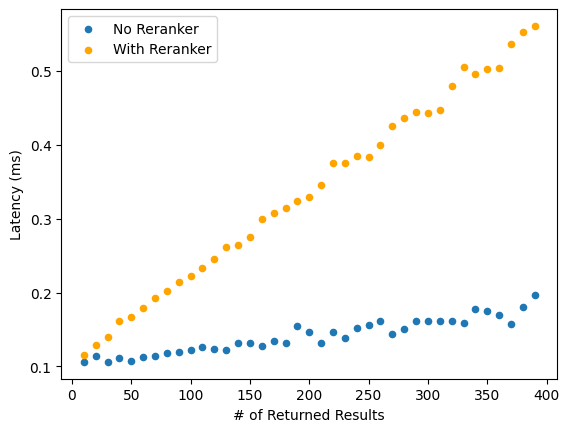

In [65]:
def time_search(limit: int, rerank: bool=True):
    start = time.perf_counter()
    response = client.keyword_search('how do I make a million dollars', 'Impact_theory_minilm_256', limit=limit, display_properties=['content', 'title'], top_k=5, rerank_results=rerank)
    end = time.perf_counter() - start
    return round(end, 3)

false_times = []
for x in tqdm(range(10, 400, 10)):
    false_times.append((time_search(x, rerank=False), x))
    

ranked_times = []
for x in tqdm(range(10, 400, 10)):
    ranked_times.append((time_search(x, rerank=True), x))

import pandas as pd

false_df = pd.DataFrame(false_times, columns=['time', 'n'])
ranked = pd.DataFrame(ranked_times, columns=['time', 'n'])

ax = false_df.plot.scatter(x='n', y='time', label='No Reranker')
ax2 = ranked.plot.scatter(x='n', y='time', ax=ax, color='orange', ylabel='Latency (ms)', label='With Reranker', xlabel='# of Returned Results')

In [ ]:
{'n': 160,
 'top_k': 5,
 'alpha': 0.3,
 'Retriever': 'sentence-transformers/all-MiniLM-L6-v2',
 'Ranker': 'cross-encoder/ms-marco-MiniLM-L-6-v2',
 'chunk_size': 256,
 'kw_hit_rate': 0.72,
 'kw_mrr': 0.57,
 'vector_hit_rate': 0.62,
 'vector_mrr': 0.51,
 'hybrid_hit_rate': 0.74,
 'hybrid_mrr': 0.58,
 'total_misses': 66,
 'total_questions': 250,
 'rerank_top_k': 5}